# Uebung 2

# 2) Eigengesichter

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mp
import tarfile
import os.path
import urllib.request
import skimage

In [2]:
filename = "lfw-funneled.tgz"
url = "http://vis-www.cs.umass.edu/lfw/" + filename
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)
    dateDownloaded = !date
    print(dateDownloaded)

In [70]:
tar = tarfile.open(filename)
tar.extractall()
tar.close()
foldername = "lfw_funneled"

In [71]:
persons = {}
for personName in os.listdir(foldername):
    current_person = foldername + "/" + personName
    if os.path.isdir(current_person):
        if len(os.listdir(current_person)) >= 70:
               persons.update({personName: [current_person +"/"+item for item in os.listdir(current_person)] })
persons.keys()

dict_keys(['Tony_Blair', 'Gerhard_Schroeder', 'Hugo_Chavez', 'George_W_Bush', 'Ariel_Sharon', 'Donald_Rumsfeld', 'Colin_Powell'])

In [85]:
from skimage import io
from skimage import transform

resized_images = []
resized_names = []

for person_name, person in zip(persons.keys(), persons.values()):
    path = person.copy()
    del path[-1]
    for picture_path in path:
        picture = io.imread(picture_path)
        resized_images.append(transform.resize(image, (32, 32)).flatten())
        resized_names.append(person_name)

resized_images = np.array(resized_images)
resized_names = np.array(resized_names)
        
resized_images.shape

(1281, 1024)

In [114]:
U, D, Vt = np.linalg.svd(resized_images)
U.shape, D.shape, Vt.shape

((1281, 1281), (1024,), (1024, 1024))

Populating the interactive namespace from numpy and matplotlib


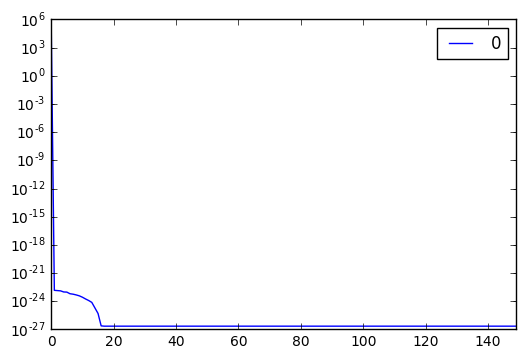

In [115]:
eigenvalues = np.square(D)
eigen_values_dataframe = pd.DataFrame(eigenvalues[0:150])

%pylab inline
eigen_values_dataframe.plot(logy=True)

In [116]:
%load_ext version_information
%version_information numpy, pandas, matplotlib

Software versions
Python 3.5.2 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.4.0 47 generic x86_64 with debian 8.5
numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
Wed Nov 16 16:31:00 2016 UTC